In [1]:
import numpy as np
import matplotlib.pyplot as plt 

## Задача 3

In [45]:
f = lambda x: 10*np.sin(x)

In [46]:
x = np.random.uniform(low = 0, high = 6.0, size = 7)
x_new = np.linspace(0, 6, 100)
x = np.sort(x)
e = np.random.randn(7)
y = f(x) + e
y_true = f(x)

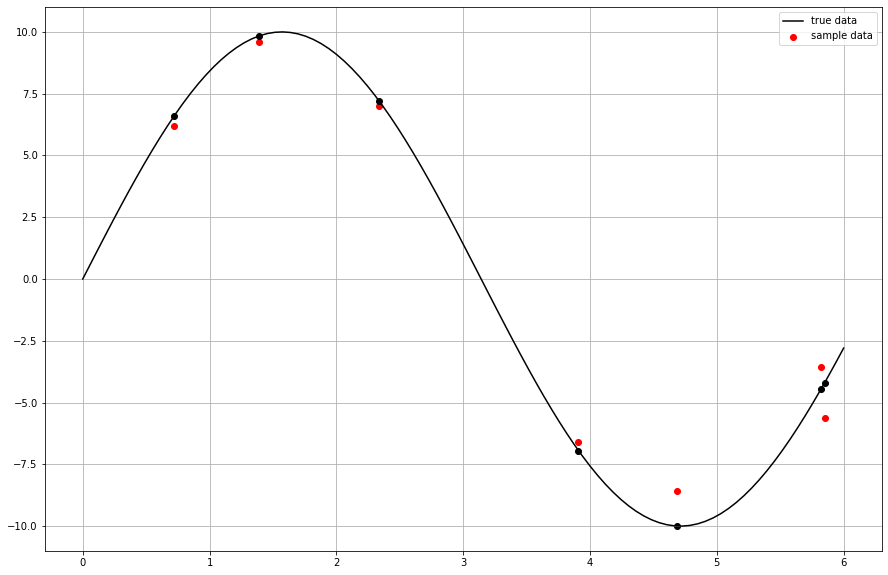

In [47]:
plt.figure(figsize = (15, 10))
plt.scatter(x, y, c = 'red', label = 'sample data')
plt.scatter(x, y_true, c = 'black')
plt.plot(x_new, f(x_new), c= 'black', label = 'true data')
plt.legend()
plt.grid()

In [48]:
#linear fit
A = np.ones(14).reshape(7, 2)
A[:, 1] = x

QR = np.linalg.qr(A)
R_inv = np.linalg.inv(QR[1])
w_1 = R_inv@QR[0].T@y

In [49]:
#cubic fit
x = x.reshape(7, 1)
A = np.concatenate((np.ones(7).reshape(7, 1), x, x**2, x**3), axis = 1)
QR = np.linalg.qr(A)
R_inv = np.linalg.inv(QR[1])
w_3 = R_inv@QR[0].T@y


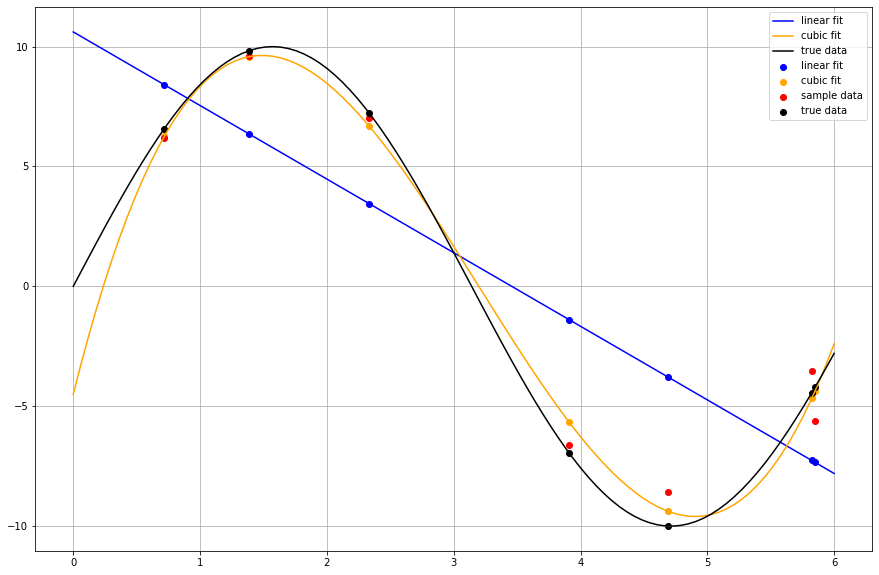

In [50]:
y_1 = lambda x: w_1[0] + w_1[1]*x
y_3 = lambda x: w_3[0] + w_3[1]*x + w_3[2]*x**2 + w_3[3]*x**3
plt.figure(figsize = (15, 10))
plt.plot(x_new, y_1(x_new), label = 'linear fit', c = 'blue')
plt.plot(x_new, y_3(x_new), label = 'cubic fit', c = 'orange')
plt.scatter(x, y_1(x), label = 'linear fit', c = 'blue')
plt.scatter(x, y_3(x), label = 'cubic fit', c = 'orange')
plt.scatter(x, y, c = 'red', label = 'sample data')
plt.plot(x_new, f(x_new), c = 'black', label = 'true data')
plt.scatter(x, y_true, c = 'black', label = 'true data')
plt.legend()
plt.grid()

## Задача 6

In [51]:
used_index_pair = list()
d = dict()

def unique_corrections(theta_indices): #Возвращает количество поправок, которое надо найти
  variables = np.unique(theta_indices)
  for i, item in enumerate(variables):
    d[item] = np.array([2*i, 2*i+1])
  return max(variables.shape)


def row_of_A_sys(A, indices, value, uc): #Возвращает строку матрицы системы
  row = np.ones(2*uc)
  zero_index = set(range(2*uc))-(set(d[indices[0]])|set(d[indices[1]])|set(d[indices[2]]))
  if len(zero_index) != 0:
    row[np.array(list(zero_index))] = np.zeros(len(zero_index))
  i, j, k = indices - 1 
  r_ki = (A[k, :] - A[i, :]).reshape(-1, 1)
  r_ji = (A[j, :] - A[i, :]).reshape(-1, 1)
  alpha = np.sqrt((r_ki.T@r_ki)*(r_ji.T@r_ji))*np.cos(value)
  betta = np.sqrt((r_ki.T@r_ki)/(r_ji.T@r_ji))*np.cos(value)
  gamma = np.sqrt((r_ji.T@r_ji)/(r_ki.T@r_ki))*np.cos(value)
  b = alpha - r_ki.T@r_ji
  #ix
  row[d[indices[0]][0]] = -(r_ki.T - betta*r_ji.T)[0][0] - (r_ji.T-gamma*r_ki.T)[0][0]
  #iy
  row[d[indices[0]][1]] = -(r_ki.T - betta*r_ji.T)[0][1] - (r_ji.T-gamma*r_ki.T)[0][1]
  #jx
  row[d[indices[1]][0]] = (r_ki.T - betta*r_ji.T)[0][0]
  #jy
  row[d[indices[1]][1]] = (r_ki.T - betta*r_ji.T)[0][1] 
  #kx
  row[d[indices[2]][0]] = (r_ji.T-gamma*r_ki.T)[0][0]
  #ky
  row[d[indices[2]][1]] = (r_ji.T-gamma*r_ki.T)[0][1]
  return row, b

def corrections(A, theta_indices, theta_values):
  theta_indices = theta_indices.reshape(-1, 3)
  n = max(A.shape)
  k = max(theta_values.shape)
  uc = unique_corrections(theta_indices)
  A_sys = np.ones((k, 2*uc))
  b_sys = np.ones(k)
  for p in range(k):
    row, b = row_of_A_sys(A, theta_indices[p, :], theta_values[p], uc)
    A_sys[p,:] = row
    b_sys[p] = b
    dr_algo = np.linalg.pinv(A_sys)@b_sys
  return [A_sys, b_sys,dr_algo, A + dr_algo.reshape(-1, 2)]

  
# output of form [LS matrix, LS constants, corrections, corrected points]


  

In [52]:
#test_2
A_npz = np.load('./drive/MyDrive/Numerical_methods/data_2.npz')
A = A_npz['r']
theta_indices = A_npz['p']
theta_values = A_npz['theta']
dr = A_npz['dr']

_, _, dr_algo, _ = corrections(A, theta_indices, theta_values)
dr_algo = dr_algo.reshape(-1, 2)

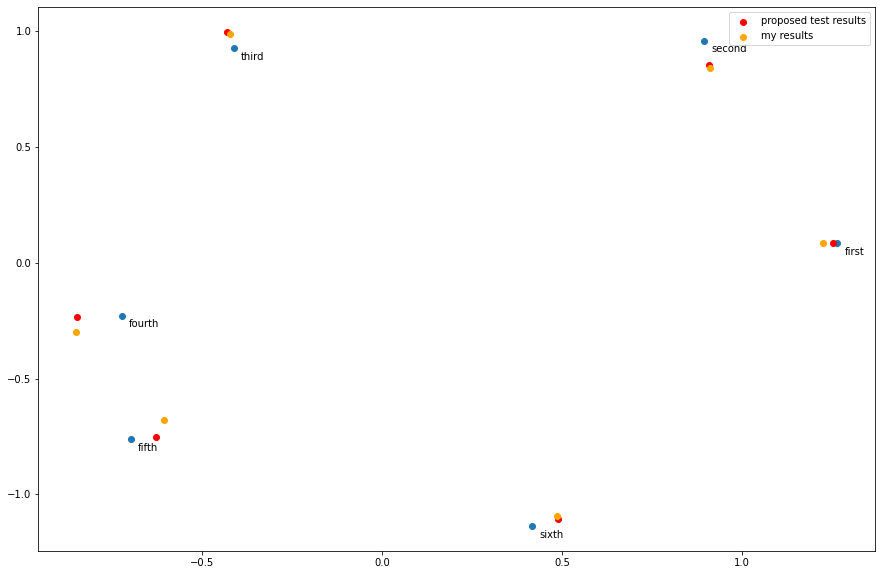

In [53]:
number_points = max(A.shape)

text = ["first", "second", "third", "fourth", "fifth", "sixth"]
x = A[:, 0]
y = A[:, 1]
x_new = A[:, 0]+dr[:, 0]
y_new = A[:, 1]+dr[:, 1]
x_new_2 = A[:, 0]+dr_algo[:, 0]
y_new_2 = A[:, 1]+dr_algo[:, 1]
plt.figure(figsize = (15, 10))
plt.scatter(x, y)
plt.scatter(x_new, y_new, c = 'red', label = 'proposed test results')
plt.scatter(x_new_2, y_new_2, c = 'orange', label = 'my results')
plt.legend()

for i in range(number_points):
    plt.annotate(text[i], (x[i]+0.02, y[i]-0.05))

In [54]:
# MSE of angles

def metric(A, dr, theta_indices):
  A = A + dr
  cos_list = list()
  for p in range(theta_indices.shape[0]):
    i,j,k = theta_indices[p, :] - 1
    r_i = A[i, :]
    r_j = A[j, :]
    r_k = A[k, :]
    tmp = (r_k-r_i)@(r_j-r_i)/np.sqrt((r_k-r_i)@(r_k-r_i))/np.sqrt((r_j-r_i)@(r_j-r_i))
    cos_list.append(tmp)
  return np.mean((np.arccos(cos_list) - theta_values)**2)


  


In [55]:
# proposed test results
metric(A, dr, theta_indices)

3.252697036791736e-05

In [56]:
# my results
metric(A, dr_algo, theta_indices)

0.006237932734865795

## Задача 4

In [57]:
with np.load ('./drive/MyDrive/Numerical_methods/data.npz') as data :
    A, C = data ['A'], data ['C']

In [58]:
print(A.shape)
print(C.shape)

(25, 60)
(1500, 816)


In [59]:
def mat2vec(A):
  A = np.flipud(A)
  a = np.reshape(A, np.prod(A.shape))
  return a

def vec2mat(a, shape):
  A = np.reshape(a, shape)
  A = np.flipud(A)
  return A

In [60]:
a = mat2vec(A)

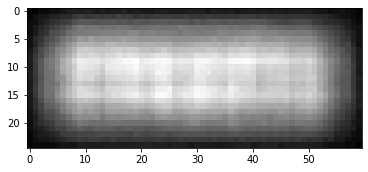

In [61]:
plt.imshow(A, cmap = 'gray')

In [62]:
# a = Ca0 the system is overdetermined

def solution(C, a):
  SVD = np.linalg.svd(C, full_matrices=False)
  b = SVD[0].T@a
  w = b/SVD[1]
  a0 = SVD[2].T@w
  return a0

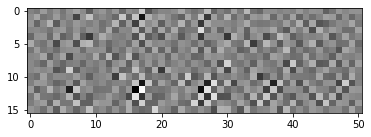

In [63]:
# naive solution
a0 = solution(C, a)
plt.imshow(vec2mat(a0, shape = (16, 51)), cmap = 'gray')

In [64]:
C_SVD = np.linalg.svd(C, full_matrices=False)

def lowrank_approx(k):
  C = C_SVD[0][:, :k]@np.diag(C_SVD[1][:k])@C_SVD[2][:k, :]
  return C

a0_list = list()
for number in range(1, 816, 15):
  C_tmp = lowrank_approx(number)
  a0_list.append(solution(C_tmp, a))
  

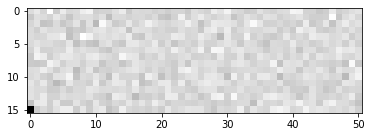

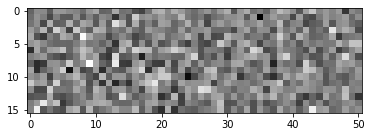

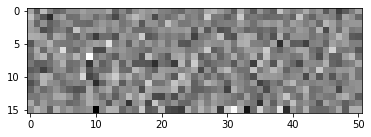

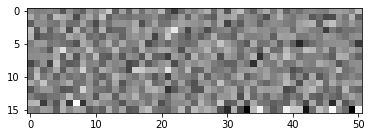

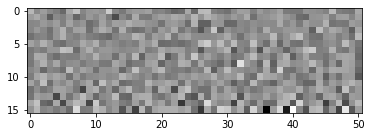

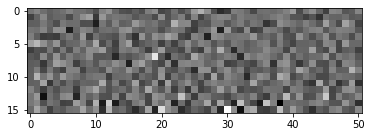

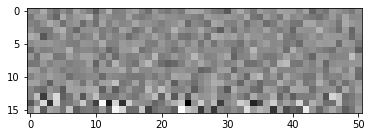

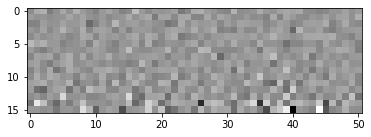

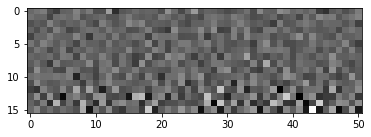

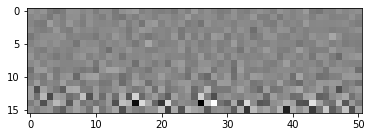

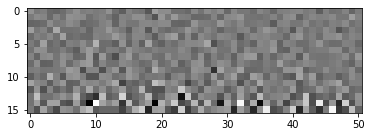

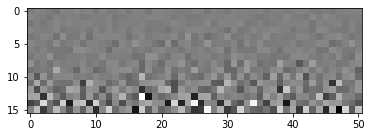

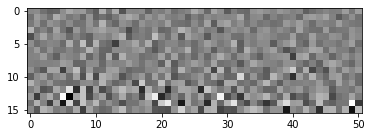

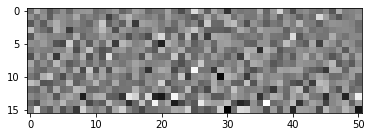

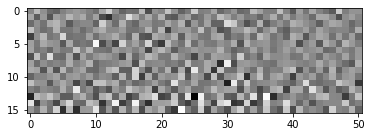

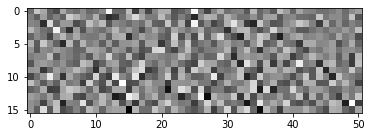

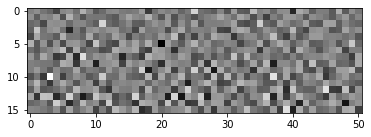

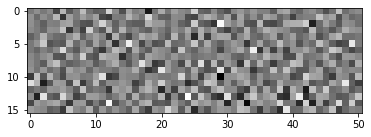

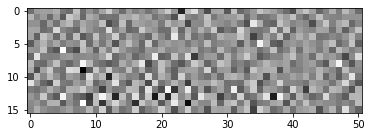

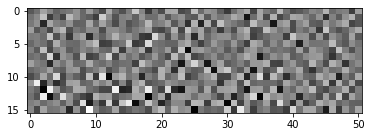

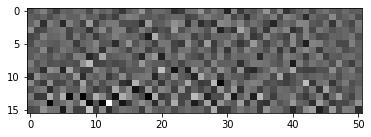

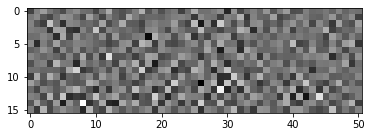

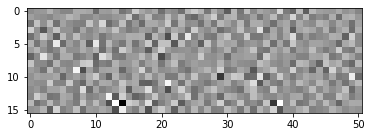

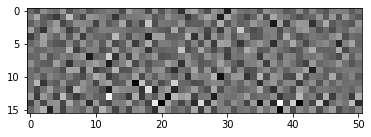

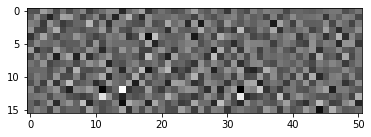

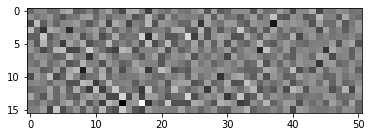

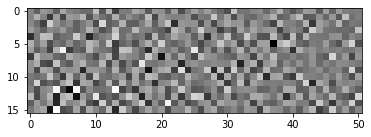

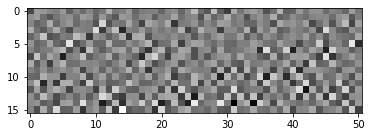

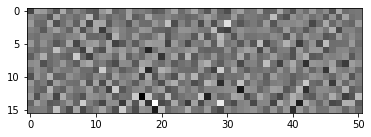

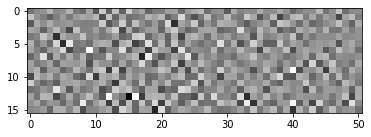

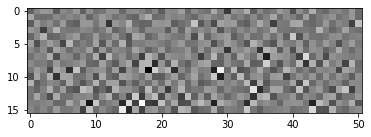

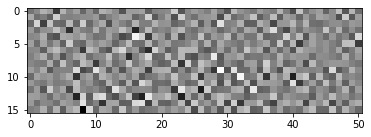

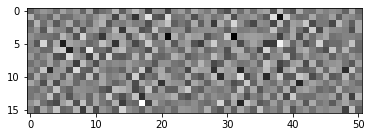

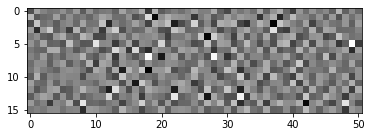

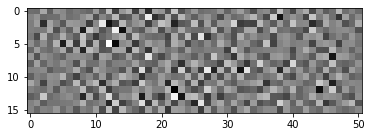

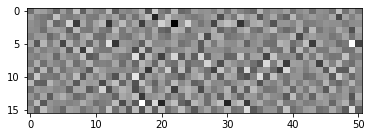

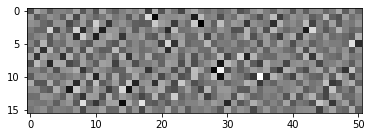

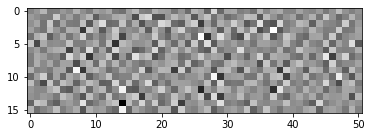

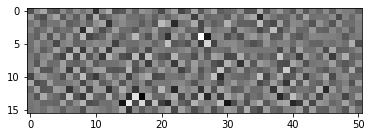

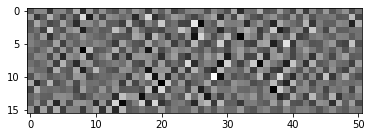

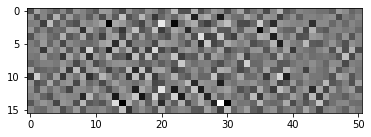

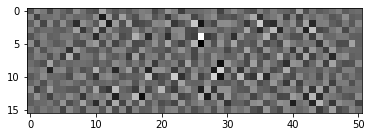

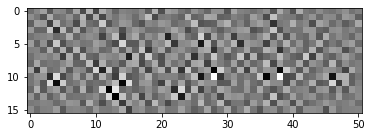

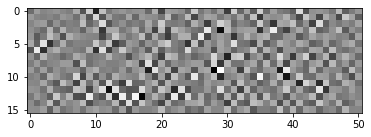

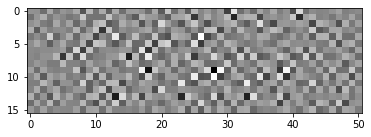

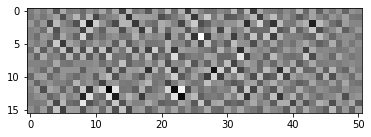

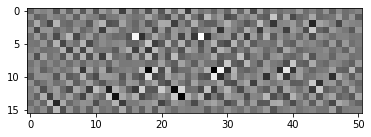

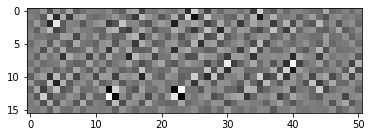

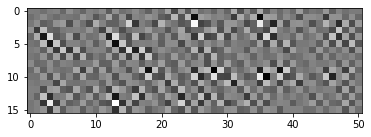

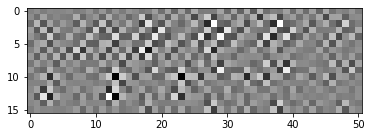

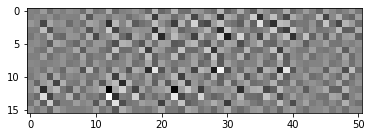

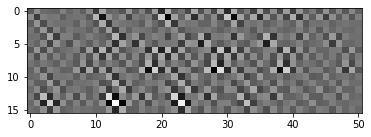

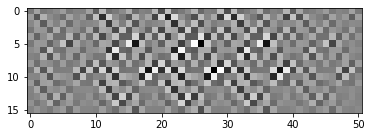

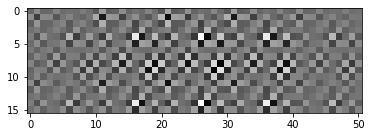

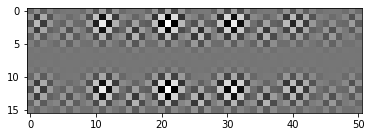

In [65]:
for item in a0_list:
  plt.imshow(vec2mat(item, shape = (16, 51)), cmap = 'gray')
  plt.show()

In [66]:
#don't know what to choose)

## Задача 2

In [76]:
A = np.zeros((2, 10))
A[0, :] = np.arange(9, -1, -1)+0.5
A[1, :] = np.ones(10)

a = np.array([1, 0])

In [83]:
f = A.T@np.linalg.inv(A@A.T)@a

In [85]:
# solution of minimal euclidian norm
f

array([ 0.05454545,  0.04242424,  0.03030303,  0.01818182,  0.00606061,
       -0.00606061, -0.01818182, -0.03030303, -0.04242424, -0.05454545])

In [82]:
np.linalg.norm(f)

0.11009637651263605